# Career Trajectories

## 8.1 Introduction

This chapter analyzes career trajectories using batting data from the Lahman database. We'll examine how player performance changes over time, focusing on Mickey Mantle as a case study.

## 8.2 Mickey Mantle's Batting Trajectory

### Load Lahman data

Using the Lahman database to obtain season-by-season hitting statistics for Mickey Mantle.

In [29]:
import pandas as pd
import numpy as np

people = pd.read_csv('../data/lahman/People.csv')
batting = pd.read_csv('../data/lahman/Batting.csv')

Extract Mickey Mantle's playerID from the People data frame.

In [30]:
mantle_id = people.loc[
    (people['nameFirst'] == 'Mickey') & (people['nameLast'] == 'Mantle'),
    'playerID'
].iloc[0]

print(mantle_id)

mantlmi01


Certain statistics like SF (sacrifice flies) and HBP (hit by pitch) were not recorded for older seasons and are coded as `NaN`. Recode these missing values to 0.

In [31]:
batting = batting.fillna({'SF': 0, 'HBP': 0})

### Compute player age and statistics

Major League Baseball defines a player's age as their age on June 30 of that season. The `get_stats()` function computes:
- **Age**: Adjusted for birth month (if born July or later, add 1 to birth year)
- **SLG**: Slugging percentage
- **OBP**: On-base percentage  
- **OPS**: On-base plus slugging

In [32]:
def get_stats(player_id):
    player_batting = batting[batting['playerID'] == player_id].copy()
    
    player_info = people[people['playerID'] == player_id].iloc[0]
    
    # Adjust birth year if born in July or later
    birthyear = player_info['birthYear']
    if player_info['birthMonth'] >= 7:
        birthyear += 1
    
    player_batting['Age'] = player_batting['yearID'] - birthyear
    
    # Calculate slugging percentage (SLG)
    player_batting['SLG'] = (
        (player_batting['H'] - player_batting['2B'] - player_batting['3B'] - player_batting['HR'] + 
         2 * player_batting['2B'] + 
         3 * player_batting['3B'] + 
         4 * player_batting['HR']) / player_batting['AB']
    )
    
    # Calculate on-base percentage (OBP)
    player_batting['OBP'] = (
        (player_batting['H'] + player_batting['BB'] + player_batting['HBP']) / 
        (player_batting['AB'] + player_batting['BB'] + player_batting['HBP'] + player_batting['SF'])
    )
    
    # Calculate OPS
    player_batting['OPS'] = player_batting['SLG'] + player_batting['OBP']
    
    return player_batting[['Age', 'SLG', 'OBP', 'OPS']]

Apply the function to get Mickey Mantle's career statistics.

In [33]:
mantle_stats = get_stats(mantle_id)
mantle_stats

,Age,SLG,OBP,OPS
70266,19.0,0.442815,0.348958,0.791774
70267,20.0,0.530055,0.394231,0.924285
70268,21.0,0.496746,0.398148,0.894894
70269,22.0,0.524862,0.408320,0.933182
70270,23.0,0.611219,0.430818,1.042036
70271,24.0,0.705441,0.463902,1.169343
70272,25.0,0.664557,0.512039,1.176595
70273,26.0,0.591522,0.443252,1.034774
70274,27.0,0.513863,0.390282,0.904145
70275,28.0,0.557875,0.399068,0.956943


### Plotting OPS vs Age

OPS (on-base plus slugging) is a comprehensive measure of batting performance. Plotting OPS against age reveals how Mantle's performance changed throughout his career.

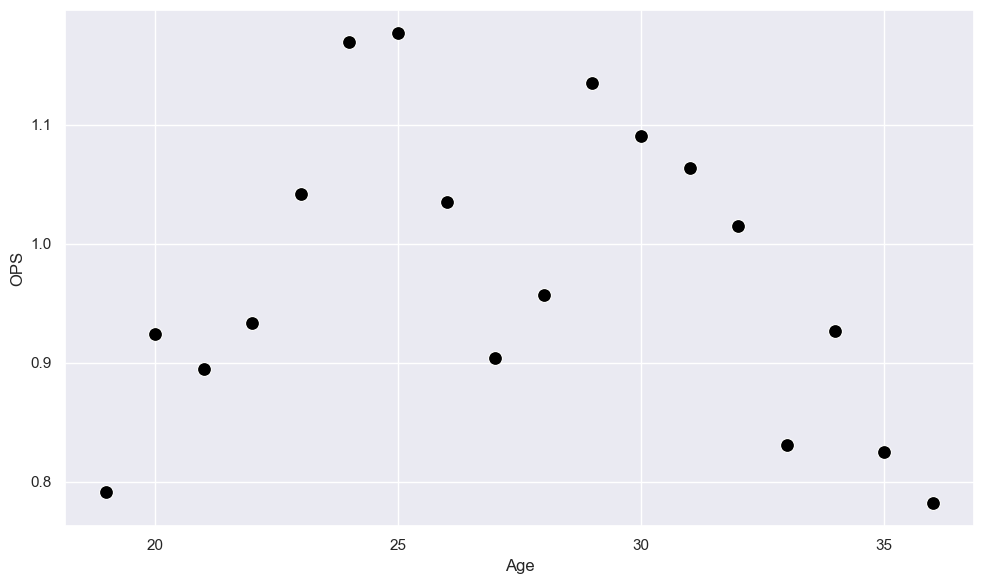

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('OPS', fontsize=12)
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()

### Fitting a Quadratic Model

A quadratic curve models the career trajectory, where performance increases to a peak age and then declines. The model is:

$$\text{OPS} \sim (Age - 30) + (Age - 30)^2$$

This centers the age variable at 30, making coefficients easier to interpret.

In [35]:
import statsmodels.api as sm

def fit_model(d):
    # Create centered age variables
    d = d.copy()
    d['Age_centered'] = d['Age'] - 30
    d['Age_squared'] = (d['Age'] - 30) ** 2
    
    # Prepare features with intercept
    X = sm.add_constant(d[['Age_centered', 'Age_squared']])
    y = d['OPS']
    
    # Fit the model
    fit = sm.OLS(y, X).fit()
    
    # Calculate peak metrics
    b0 = fit.params['const']
    b1 = fit.params['Age_centered']
    b2 = fit.params['Age_squared']
    Age_max = 30 - b1 / b2 / 2
    Max = b0 - b1 ** 2 / b2 / 4
    
    return {'fit': fit, 'Age_max': Age_max, 'Max': Max}

Fit the quadratic model to Mantle's career data.

In [36]:
mantle_fit = fit_model(mantle_stats)

print(mantle_fit['fit'].params)

const           1.043134
Age_centered   -0.022883
Age_squared    -0.003869
dtype: float64


In [37]:
print(f"Age at peak: {mantle_fit['Age_max']:.2f}")
print(f"Maximum OPS: {mantle_fit['Max']:.2f}")

Age at peak: 27.04
Maximum OPS: 1.08


The best fitting curve is given by:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mn>1.04313</mn>
  <mo>&#x2212;</mo>
  <mn>0.02288</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mn>0.00387</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <msup>
    <mo stretchy="false">)</mo>
    <mn>2</mn>
  </msup>
  <mstyle scriptlevel="0">
    <mspace width="0.167em"></mspace>
  </mstyle>
</math>

Mantle's peak: age 27, OPS 1.08. The curvature parameter (-0.00387) shows OPS declined ~0.004 per year after peak performance.

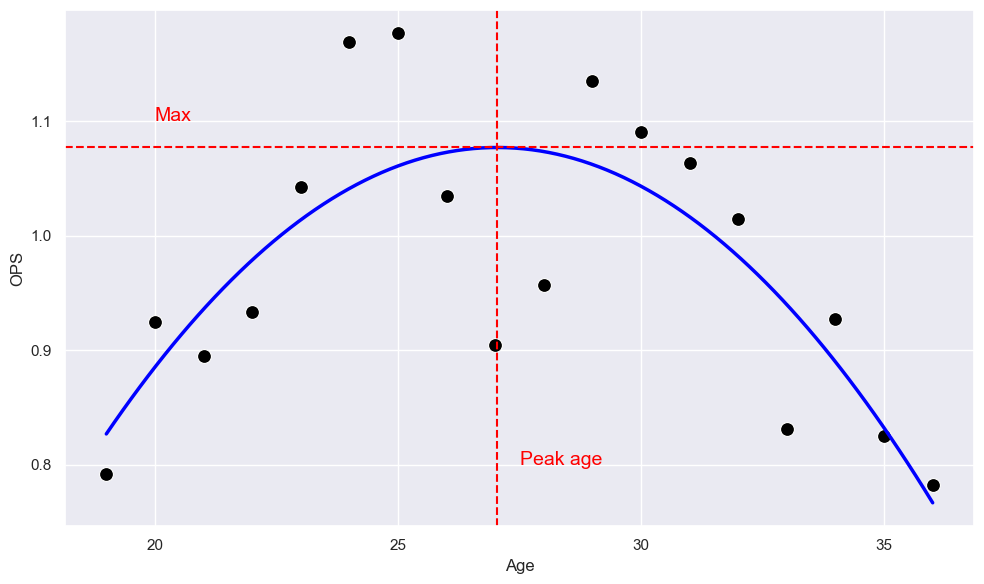

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of actual data
sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

# Generate predictions for smooth curve
age_range = np.linspace(mantle_stats['Age'].min(), mantle_stats['Age'].max(), 100)
age_centered = age_range - 30
age_squared = age_centered ** 2

# Create prediction dataframe with constant term
X_pred = pd.DataFrame({
    'Age_centered': age_centered,
    'Age_squared': age_squared
})
X_pred = sm.add_constant(X_pred)

ops_pred = mantle_fit['fit'].predict(X_pred)

# Plot fitted curve
ax.plot(age_range, ops_pred, color='blue', linewidth=2.5)

# Add vertical line for peak age
ax.axvline(x=mantle_fit['Age_max'], color='red', linestyle='--')

# Add horizontal line for max OPS
ax.axhline(y=mantle_fit['Max'], color='red', linestyle='--')

# Add annotations
ax.text(27.5, 0.8, 'Peak age', color='red', fontsize=14)
ax.text(20, 1.1, 'Max', color='red', fontsize=14)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('OPS', fontsize=12)
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()


In [39]:
mantle_fit['fit'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    OPS   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     11.34
Date:                Sat, 27 Dec 2025   Prob (F-statistic):            0.00100
Time:                        23:40:41   Log-Likelihood:                 20.640
No. Observations:                  18   AIC:                            -35.28
Df Residuals:                      15   BIC:                            -32.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0431      0.028     37.387      0.000       0.984       1.103
Age_centered    -0.0229      0.006     -4.059      0.001      -0.035      -0.011
Age_squared     -0.0039      0.001     -4.671      0.000      -0.006      -0.002
==============================================================================
Omnibus:                        1.098   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.721
Skew:                          -0.472   Prob(JB):                        0.697
Kurtosis:                       2.738   Cond. No.                         68.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
print(f"Residual Standard Error: {np.sqrt(mantle_fit['fit'].mse_resid)}")

Residual Standard Error: 0.08420947610713088


R² = 0.602 the model explains 60% of OPS variability. The residual standard error of 0.084 indicates that approximately 68% of the model's predictions fall within ±0.084 OPS of the actual values.



## 8.3 Comparing Trajectories

### 8.3.1 Some preliminary work

In [41]:
# Calculate career at-bats for each player
career_ab = batting.groupby('playerID')['AB'].sum().reset_index()
career_ab.columns = ['playerID', 'AB_career']

# Join with batting data and filter for players with >= 2000 career AB
batting_2000 = career_ab.merge(batting, on='playerID')
batting_2000 = batting_2000[batting_2000['AB_career'] >= 2000]


In [42]:
# Load fielding data
fielding = pd.read_csv('../data/lahman/Fielding.csv')

# For each player and position, sum total games played
positions = (fielding
    .groupby(['playerID', 'POS'])['G']
    .sum()
    .reset_index()
    .rename(columns={'G': 'Games'})
)

# Sort by playerID and Games (descending) to get primary position
positions = positions.sort_values(['playerID', 'Games'], ascending=[True, False])

# Keep only the first (most-played) position for each player
positions = positions.groupby('playerID').first().reset_index()

In [43]:
# Merge primary position with batting data for 2000+ AB players
batting_2000 = batting_2000.merge(
    positions[['playerID', 'POS', 'Games']], 
    on='playerID', 
    how='inner')

### 8.3.2 Computing career statistics